### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
import miceforest as mf

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'MICE_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_WO', 'SVM_poly_WO','XGBoost_WO']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
# MICE Imputation ---> Train set
imputed_data = train.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)

# Run MICE
kernel = mf.ImputationKernel(imputed_data, datasets=3, save_all_iterations=True, random_state=123)
kernel.mice(3)
imputed_data = kernel.complete_data(dataset=3-1)
imputed_data.isna().sum().sum()

0

In [8]:
train = pd.concat([train[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)

In [9]:
# MICE Imputation ---> Test set
imputed_data = test.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)

# Run MICE
kernel = mf.ImputationKernel(imputed_data, datasets=3, save_all_iterations=True, random_state=123)
kernel.mice(3)
imputed_data = kernel.complete_data(dataset=3-1)
imputed_data.isna().sum().sum()

0

In [10]:
test = pd.concat([test[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)

In [11]:
train.shape, test.shape

((1450, 48), (161, 48))

In [12]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site','id','strata','diagnosis',  'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total', 'pfeffer_total',
              'cognition', 'functionality' ]

train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [13]:
train.columns

Index(['site', 'id', 'strata', 'diagnosis', 'ifs_total_score',
       'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'barthel_total',
       'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

In [14]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 15), (161, 15))

In [15]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [16]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-26/MICE_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "MICE_RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "MICE_SVC_Poly_hparams_fcols2.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "MICE_xgb_hparams_fcols2.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [17]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                         gini
param_max_depth                                                            9
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.742076
mean_train_score                                                    0.952563
Name: 0, dtype: object

In [18]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      8.377922
param_coef0                                                         0
param_degree                                                        2
param_gamma                                                  4.437735
params              OrderedDict([('C', 8.377922372279789), ('coef0...
mean_test_score                                              0.727857
mean_train_score                                             0.823643
Name: 0, dtype: object

In [19]:
xgb_row=0
xgb_hp.iloc[0, :]

param_booster                                                       dart
param_learning_rate                                                  0.3
param_max_bin                                                          5
param_max_depth                                                        4
param_max_leaves                                                       8
param_n_estimators                                                   100
param_reg_alpha                                                     0.99
param_reg_lambda                                                     0.1
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'dart'), ('learning_r...
mean_test_score                                                 0.748765
mean_train_score                                                0.932778
Name: 0, dtype: object

In [20]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[xgb_row, 'param_booster'],
    'tree_method': xgb_hp.loc[xgb_row, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[xgb_row, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'max_bin': xgb_hp.loc[xgb_row, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[xgb_row, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[xgb_row, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [21]:
n_iter =1000

### Base model: Logistic Regression

In [22]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 1000/1000 [00:35<00:00, 28.04it/s]

singular_matrix_errors (droped from results): 883
Eleapsed time:0.5947225014368693 minutes
empirical p-value: 0.002



Casting complex values to real discards the imaginary part
invalid value encountered in sqrt
invalid value encountered in sqrt


In [23]:
lr_res.mean()

Accuracy         0.774087
ROC_AUC          0.673838
Precision        0.794292
Recall           0.055326
Sensitivity      0.055326
Specificity      0.995987
F1               0.102025
Efron_pR2        0.082955
mcfadden_pR2    -0.750918
mcfadden_apR2   -0.871735
dtype: float64

In [24]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.025919,0.029057,0.025054,0.01417,0.01417,0.003919,0.01876,0.017095,NaN,NaN


In [25]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,ace_lw,1.552130,0.136765,1.888034e-05-3.512821e-06j,1.315698e-05,0.999999,3.330669e-16
1,ace_vs,1.515595,0.136897,1.837607e-05-3.444444e-06j,1.280943e-05,0.999999,3.330669e-16
2,barthel_total,-0.225823,0.170065,-6.698905e-01+1.490884e-02j,6.156765e-01,0.904537,3.286128e-02
3,cognition,0.744577,0.056315,7.692308e-08-1.709402e-08j,2.676155e-07,1.000000,0.000000e+00
4,functionality,-0.085576,0.114059,-3.932932e-02+4.116239e-05j,5.261122e-02,0.999718,1.110223e-16


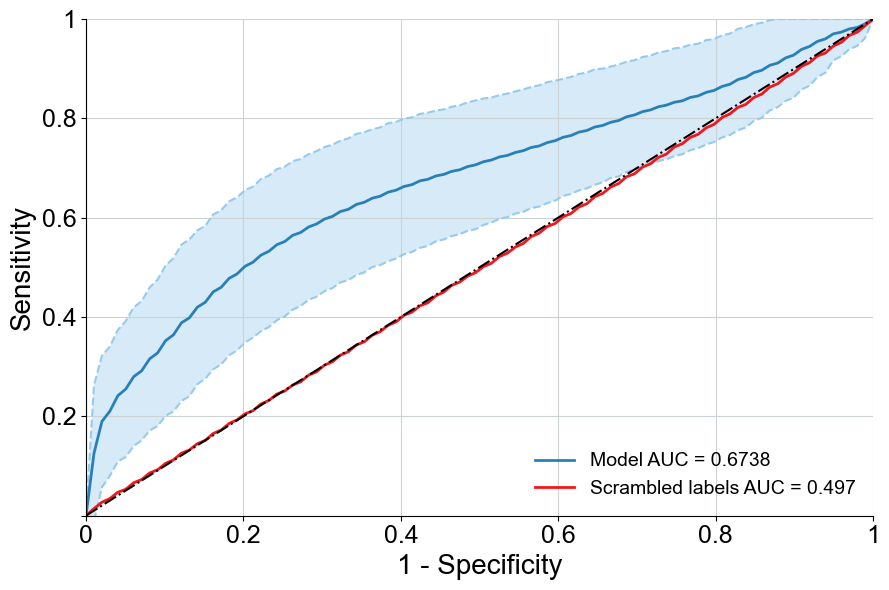

In [26]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [27]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [28]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

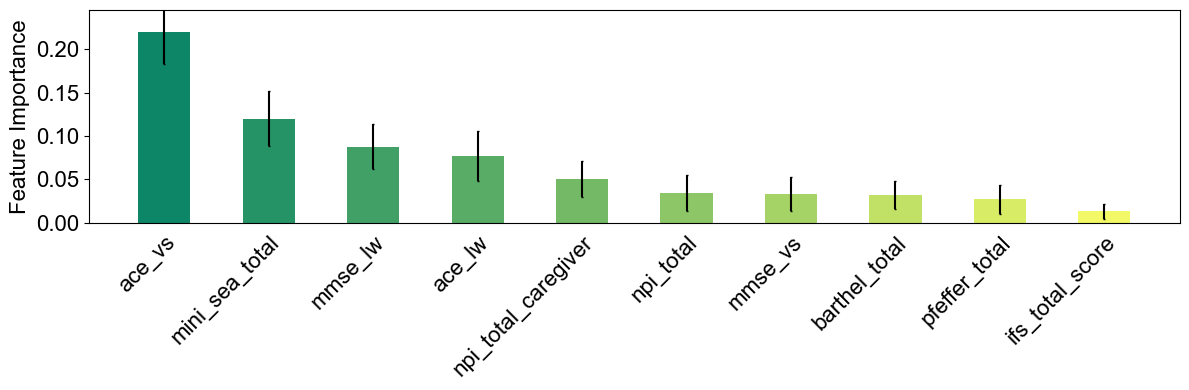

In [29]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

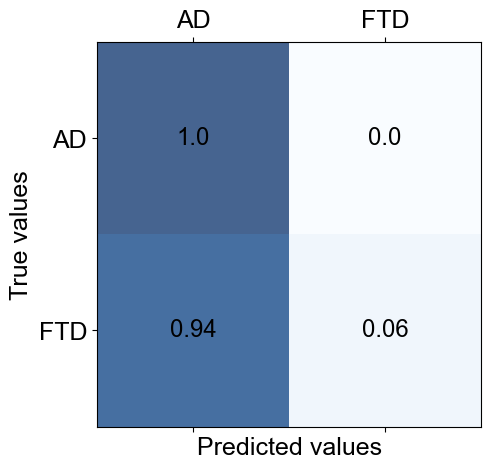

In [30]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [31]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [32]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [33]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [34]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [35]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5478
Accuracy: 0.7757
Recall: 0.12
F1: 0.2
Precision:0.6


In [36]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5478
Bootstrping test ROC score: 	0.6738


### RF Model

##### Bootstrap

In [37]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=10,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████| 1000/1000 [16:23<00:00,  1.02it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:16.397730366388956 minutes
empirical p-value: 0.0


In [38]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-09-27/MICE_res'

In [39]:
Model_res.to_csv(path_res+ "/RandomForest_WO/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.760667
ROC_AUC        0.752582
Precision      0.495116
Recall         0.500826
Sensitivity    0.500826
Specificity    0.840886
F1             0.495964
Efron_pR2      0.063245
dtype: float64

In [40]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.7526


In [41]:
CI_df.to_csv(path_res+ "/RandomForest_WO/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.026446,0.026745,0.030989,0.03099,0.03099,0.022671,0.030989,0.015086


In [42]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.197758,0.014582
0,ace_lw,0.116073,0.018159
5,ifs_total_score,0.105988,0.011157
3,cognition,0.090255,0.010723
1,ace_vs,0.086617,0.015391
11,npi_total,0.069079,0.008279
4,functionality,0.055287,0.005844
12,npi_total_caregiver,0.053079,0.004774
7,mmse_lw,0.051041,0.012071
13,pfeffer_total,0.047729,0.004567


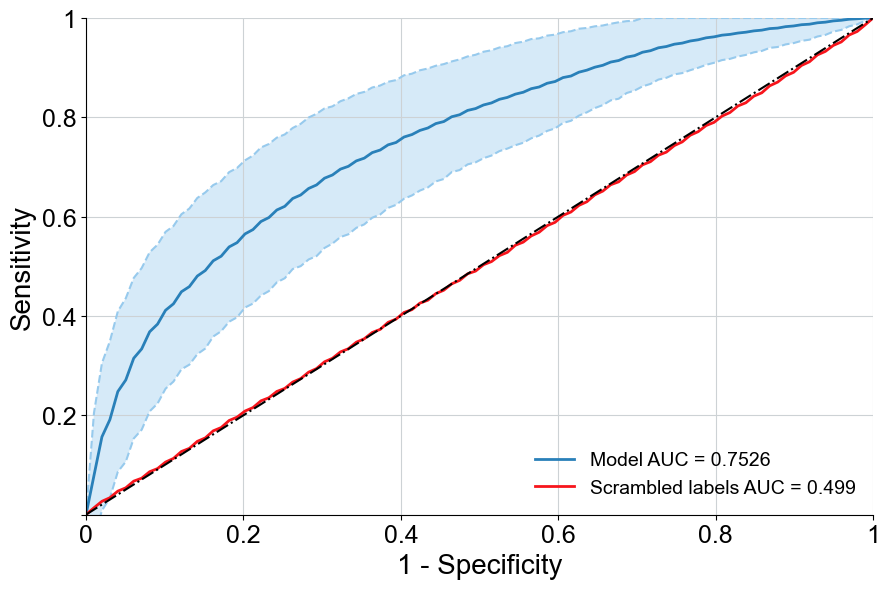

In [43]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_WO/ROC_AUC_curve.png")
# Fig save?


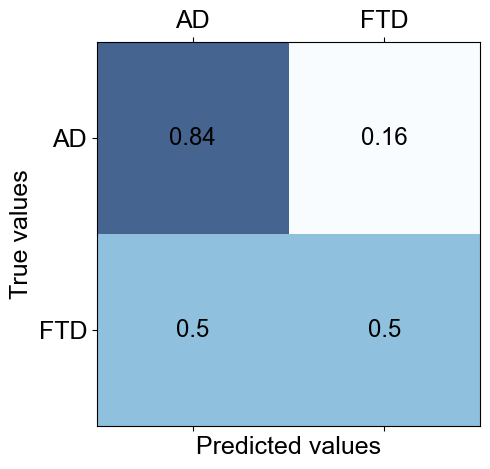

In [44]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_WO/CM.png")

##### Permutation Feature importance

In [45]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [46]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [47]:
top_10p.head()

,predictor,mean,std
1,mini_sea_total,0.086799,0.030629
9,ace_lw,0.041918,0.017676
12,cognition,0.020283,0.010912
0,ifs_total_score,0.019068,0.014984
8,ace_vs,0.014768,0.010292


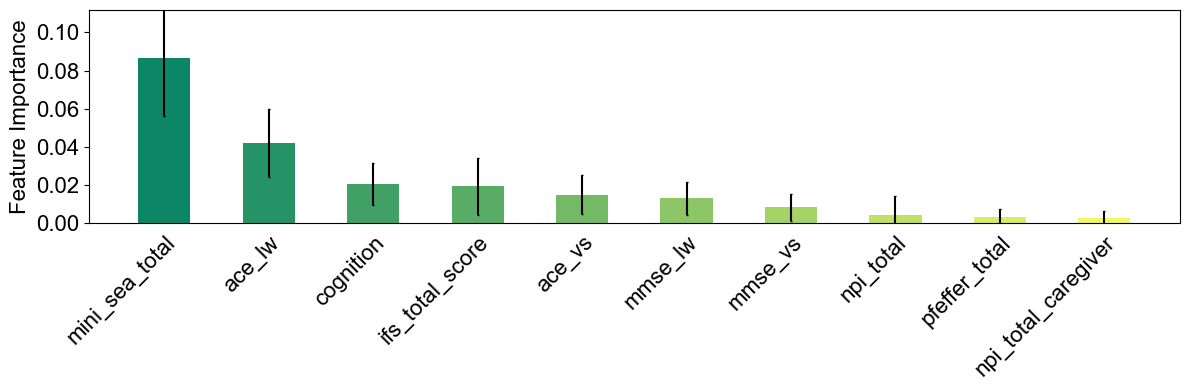

In [48]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [49]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.197758,0.014582
0,ace_lw,0.116073,0.018159
5,ifs_total_score,0.105988,0.011157
3,cognition,0.090255,0.010723
1,ace_vs,0.086617,0.015391


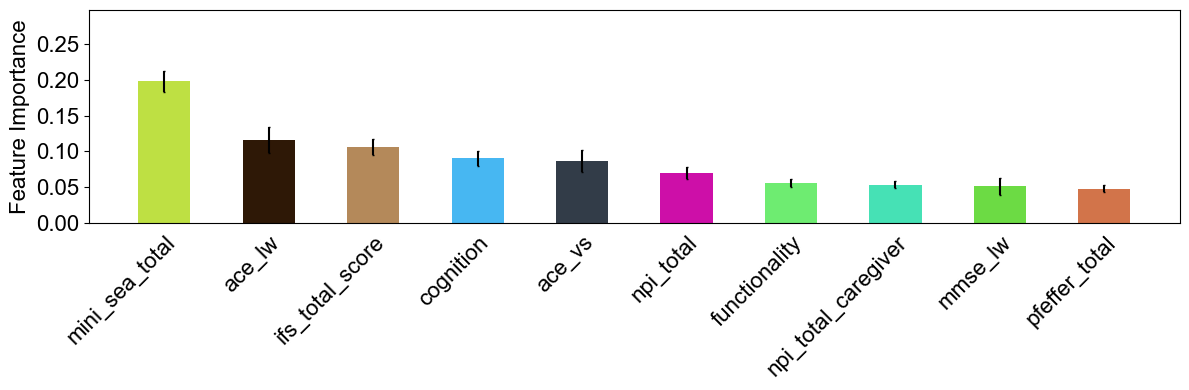

In [50]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [51]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [52]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [53]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest_WO/unseen.csv")

In [54]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.6539
Accuracy: 0.8318
Recall: 0.32
F1: 0.4706
Precision:0.8889


In [55]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.6539
Bootstrping test ROC score: 	0.7526


#### Shapley

In [56]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


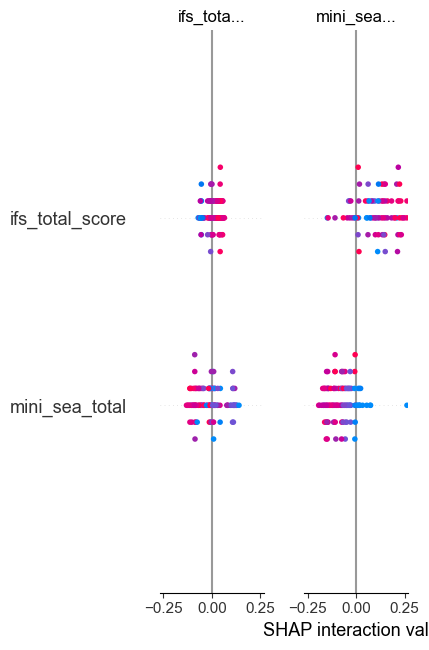

In [57]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

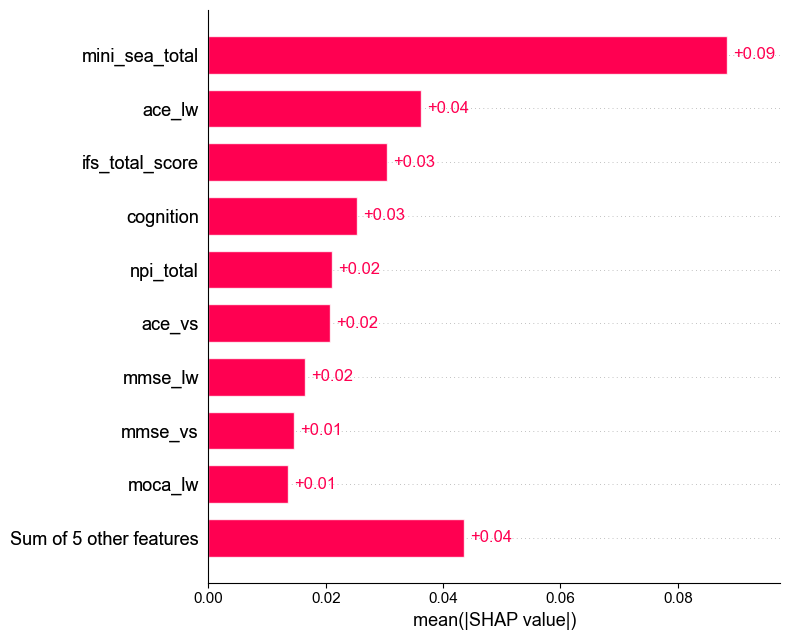

In [58]:
shap.plots.bar(shap_values[:,:,1])

In [59]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [60]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [61]:
# shap.summary_plot(shap_values2[:,:,1])

In [62]:
# shap.plots.bar(shap_values2[:,:,1])

In [63]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [64]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [65]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=8.377922372279789, class_weight='balanced', coef0=0, degree=2,
    gamma=4.437735036441617, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 1000/1000 [09:42<00:00,  1.72it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:9.716707424322765 minutes
empirical p-value: 0.002


In [66]:
p_Model_res.to_csv(path_res+ "/SVM_poly_WO/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.735303
ROC_AUC        0.679400
Precision      0.454002
Recall         0.573565
Sensitivity    0.573565
Specificity    0.785235
F1             0.505092
dtype: float64

In [67]:
p_CI_df.to_csv(path_res+ "/SVM_poly_WO/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.027344
ROC_AUC_ci        0.028927
Precision_ci      0.030859
Recall_ci         0.030653
Sensitivity_ci    0.030653
Specificity_ci    0.025453
F1_ci             0.030989
dtype: float64

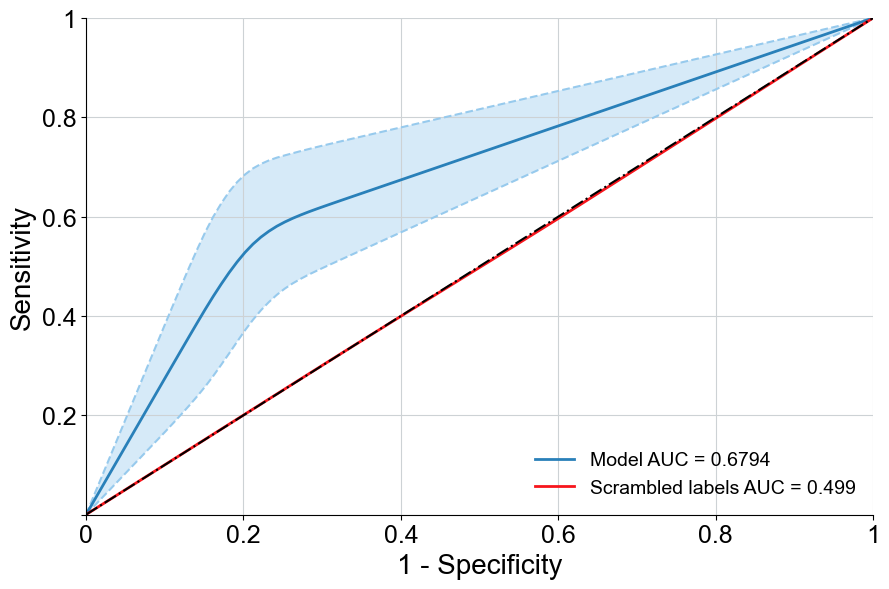

In [68]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly_WO/poly_ROC_AUC_curve.png")

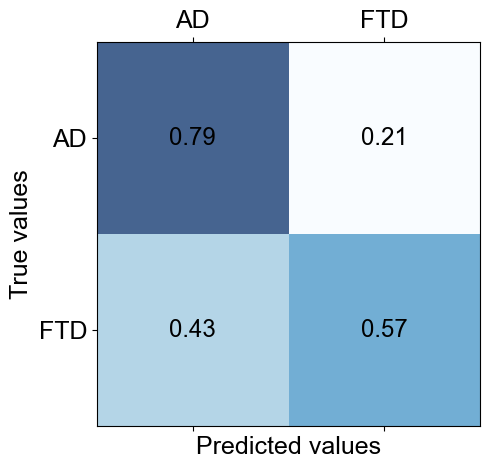

In [69]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly_WO/poly_CM.png")

#### Permutation Feature importance

In [70]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


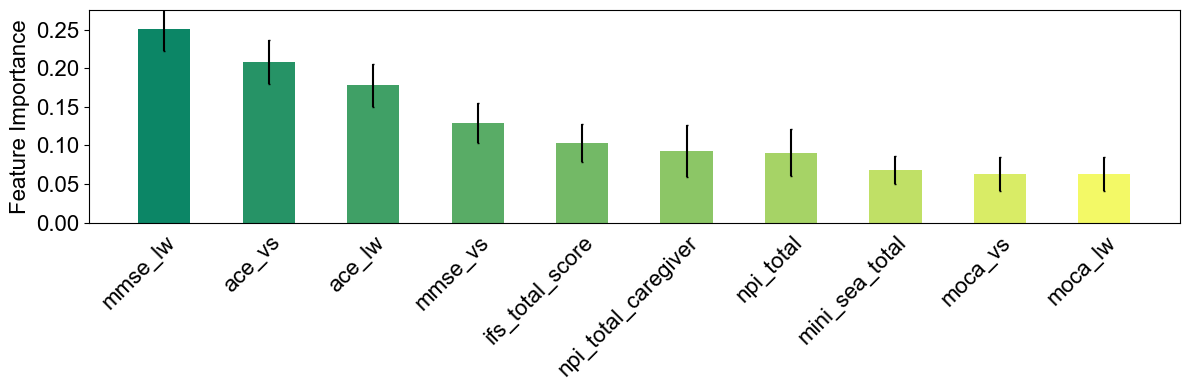

In [71]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [72]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [73]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")

In [74]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.4812
Accuracy: 0.4393
Recall: 0.56
F1: 0.3182
Precision:0.2222

Unseen Data ROC score: 		0.4812
Bootstrping test ROC score: 	0.6794


#### Shapley

In [75]:
poly_params['probability'] = True

In [76]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


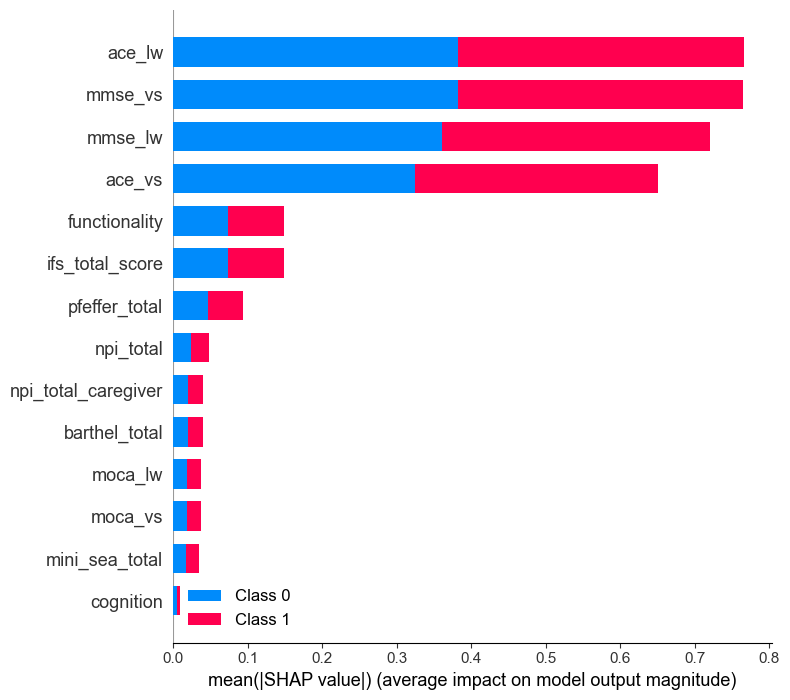

In [77]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [78]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 1000/1000 [17:43<00:00,  1.06s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:17.732858423391978 minutes
empirical p-value: 0.0


In [79]:
xgb_Model_res.to_csv(path_res+ "/XGBoost_WO/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.775636
ROC_AUC        0.735796
Precision      0.551716
Recall         0.289478
Sensitivity    0.289478
Specificity    0.925725
F1             0.376252
Efron_pR2      0.116297
dtype: float64

In [80]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost_WO/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,60.747,10.093110,1.523687,0.235309
5,ifs_total_score,54.441,10.600986,1.019142,0.200349
10,npi_total,48.503,9.790907,0.848447,0.152386
11,npi_total_caregiver,40.428,8.586649,0.735745,0.163657
9,moca_vs,36.039,7.593493,1.099969,0.254838
12,pfeffer_total,35.272,9.617823,0.974500,0.220431
2,barthel_total,30.380,7.157851,0.905313,0.192654
1,ace_vs,30.165,7.388529,1.124880,0.279755
8,mmse_vs,27.940,7.842060,1.812345,0.491726
4,functionality,21.416,6.510094,0.956487,0.269387


In [81]:
xgb_CI_df.to_csv(path_res+ "/XGBoost_WO/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.025856,0.027328,0.030824,0.028109,0.028109,0.016252,0.030026,0.01987


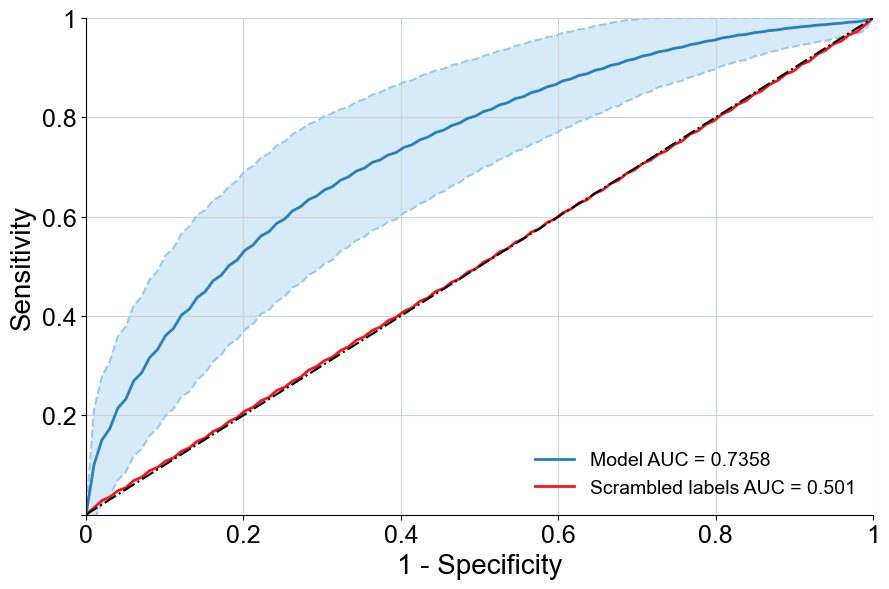

In [82]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost_WO/xgb_ROC.png")

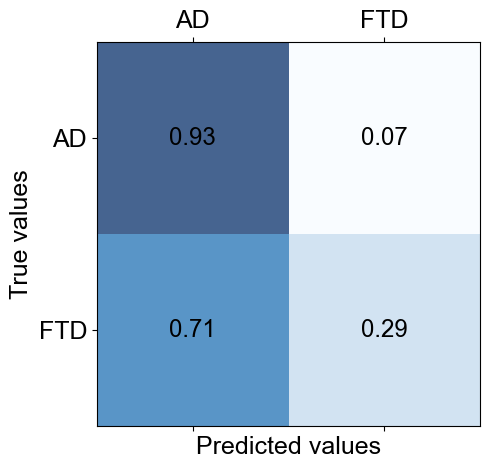

In [83]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost_WO/xgb_CM.png")

#### Permutation Feature importance

In [84]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

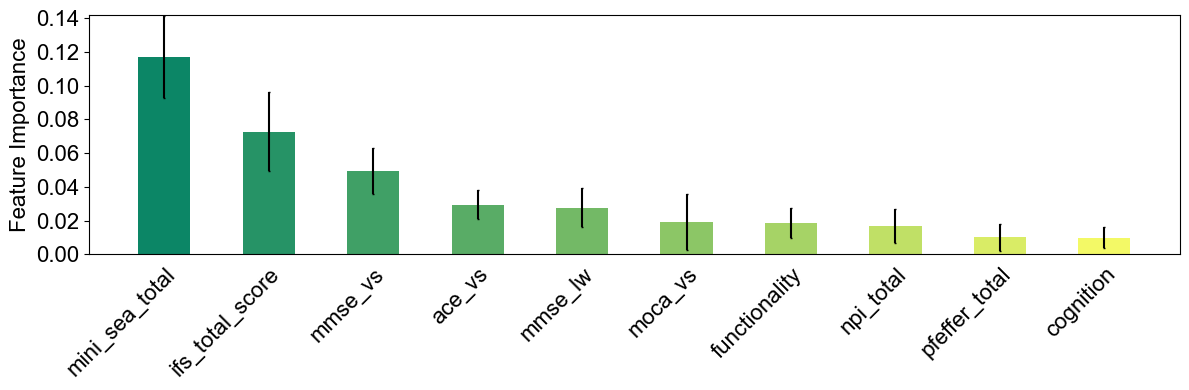

In [85]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [86]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,ace_lw,8.722,3.969442,2.182756,0.919247
1,ace_vs,30.165,7.388529,1.124880,0.279755
2,barthel_total,30.380,7.157851,0.905313,0.192654
3,cognition,17.816,6.615430,0.902700,0.345872
4,functionality,21.416,6.510094,0.956487,0.269387
5,ifs_total_score,54.441,10.600986,1.019142,0.200349
6,mini_sea_total,60.747,10.093110,1.523687,0.235309
7,mmse_lw,11.857,4.662004,5.858173,2.483612
8,mmse_vs,27.940,7.842060,1.812345,0.491726
9,moca_vs,36.039,7.593493,1.099969,0.254838


In [87]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,60.747,10.093110,1.523687,0.235309
5,ifs_total_score,54.441,10.600986,1.019142,0.200349
10,npi_total,48.503,9.790907,0.848447,0.152386
11,npi_total_caregiver,40.428,8.586649,0.735745,0.163657
9,moca_vs,36.039,7.593493,1.099969,0.254838
12,pfeffer_total,35.272,9.617823,0.974500,0.220431
2,barthel_total,30.380,7.157851,0.905313,0.192654
1,ace_vs,30.165,7.388529,1.124880,0.279755
8,mmse_vs,27.940,7.842060,1.812345,0.491726
4,functionality,21.416,6.510094,0.956487,0.269387


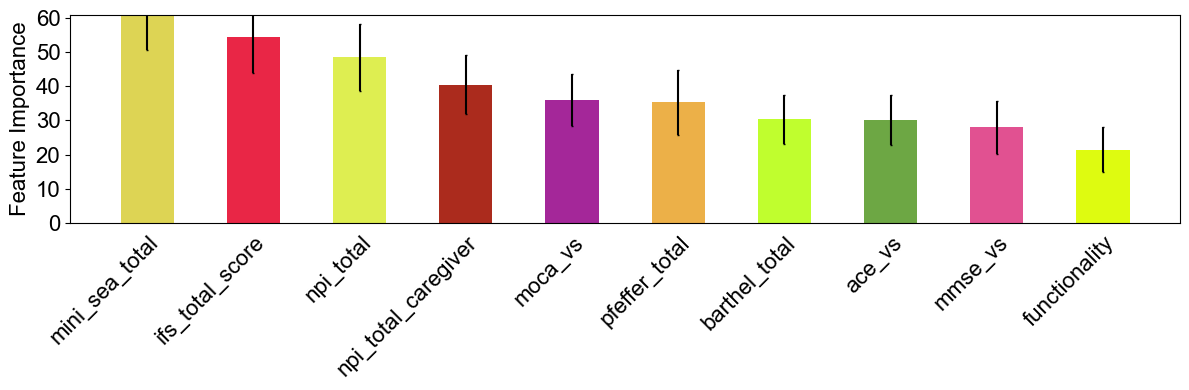

In [88]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

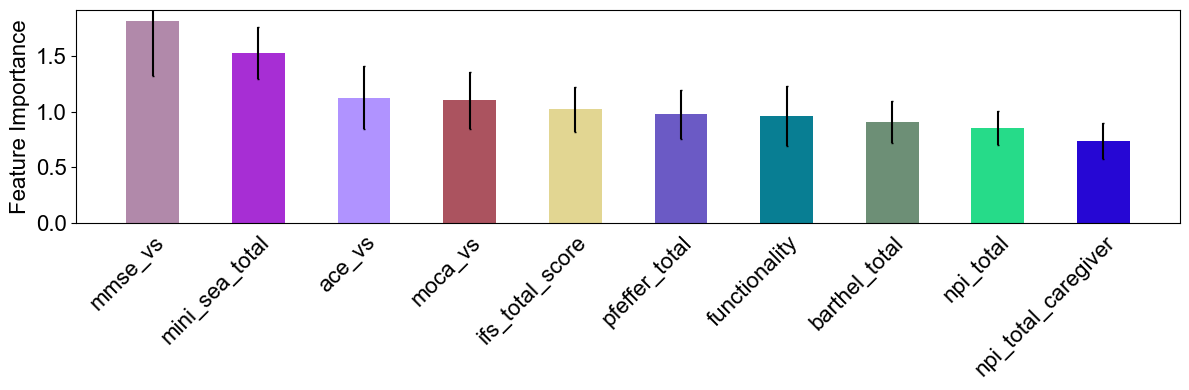

In [89]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [90]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [91]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")

In [92]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6
Accuracy: 0.8131
Recall: 0.2
F1: 0.3333
Precision:1.0

Unseen Data ROC score: 		0.6
Bootstrping test ROC score: 	0.7358


#### Shapley

In [93]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

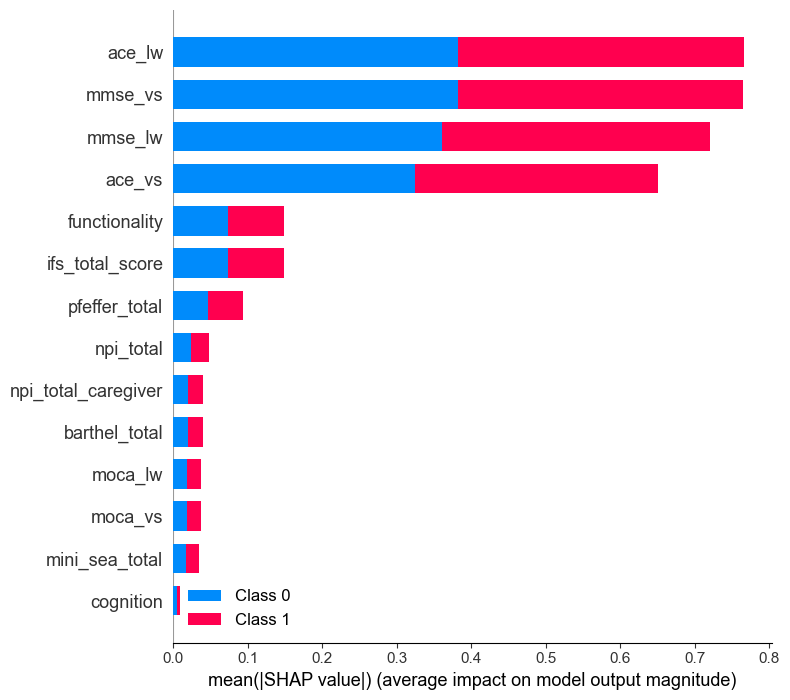

In [94]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

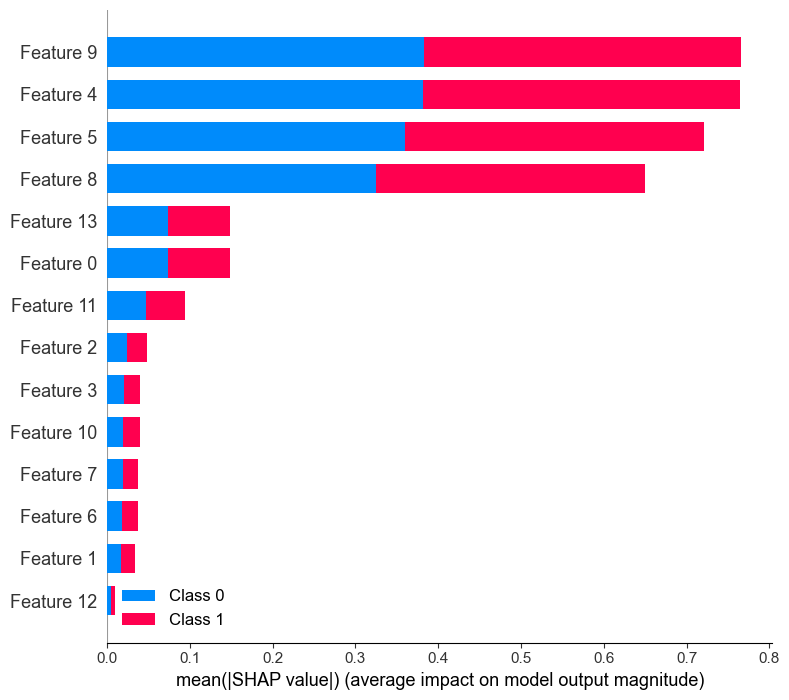

In [95]:
shap.summary_plot(shap_values)

In [96]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [98]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [99]:
rf_params

{'n_estimators': 500,
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 10,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [100]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [101]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.7s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.6s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.6s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [102]:
pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.7323076923076923, 0.72, 0.7438271604938271]",0.732045,"(cognition,)",0.021894,0.009729,0.00688
2,"(1, 12)","[0.7476923076923077, 0.7723076923076924, 0.722...",0.747407,"(mini_sea_total, cognition)",0.046015,0.020448,0.014459
3,"(1, 2, 12)","[0.7784615384615384, 0.796923076923077, 0.7469...",0.774099,"(mini_sea_total, npi_total, cognition)",0.046465,0.020648,0.0146
4,"(1, 2, 5, 12)","[0.7723076923076924, 0.7846153846153846, 0.759...",0.772061,"(mini_sea_total, npi_total, mmse_lw, cognition)",0.023298,0.010353,0.007321
5,"(1, 2, 4, 5, 12)","[0.7723076923076924, 0.7938461538461539, 0.762...",0.776167,"(mini_sea_total, npi_total, mmse_vs, mmse_lw, ...",0.029584,0.013146,0.009296
6,"(1, 2, 3, 4, 5, 12)","[0.7846153846153846, 0.7876923076923077, 0.753...",0.775131,"(mini_sea_total, npi_total, npi_total_caregive...",0.035192,0.015639,0.011058
7,"(1, 2, 3, 4, 5, 12, 13)","[0.796923076923077, 0.7907692307692308, 0.75]",0.779231,"(mini_sea_total, npi_total, npi_total_caregive...",0.046855,0.020821,0.014723
8,"(1, 2, 3, 4, 5, 7, 12, 13)","[0.8, 0.796923076923077, 0.7530864197530864]",0.783336,"(mini_sea_total, npi_total, npi_total_caregive...",0.048218,0.021427,0.015151
9,"(1, 2, 3, 4, 5, 7, 10, 12, 13)","[0.8, 0.7938461538461539, 0.7469135802469136]",0.780253,"(mini_sea_total, npi_total, npi_total_caregive...",0.053351,0.023708,0.016764
10,"(0, 1, 2, 3, 4, 5, 7, 10, 12, 13)","[0.796923076923077, 0.803076923076923, 0.74691...",0.782305,"(ifs_total_score, mini_sea_total, npi_total, n...",0.056598,0.025151,0.017784


In [103]:
from sklearn.feature_selection import SequentialFeatureSelector as ssfs
from sklearn.feature_selection import RFECV

In [104]:
rfecv_rf = RFECV(RandomForestClassifier(class_weight= 'balanced'), step=1, min_features_to_select=5, cv=cv, scoring='roc_auc', verbose=1,
      n_jobs=-1, importance_getter='auto')

In [105]:
rfecv_rf=rfecv_rf.fit(X_train, y_train)

In [106]:
X_train.columns[rfecv_rf.support_]

Index(['ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw',
       'barthel_total', 'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

### XBoost

In [107]:
sfs_xgb = SFS(xgboost.XGBClassifier(), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [108]:
sfs_xgb = sfs_xgb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.1s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [109]:
pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.8092307692307692, 0.7661538461538462, 0.75]",0.775128,"(ace_lw,)",0.056257,0.025,0.017677
2,"(8, 9)","[0.8092307692307692, 0.7661538461538462, 0.75]",0.775128,"(ace_vs, ace_lw)",0.056257,0.025,0.017677
3,"(6, 8, 9)","[0.7446153846153846, 0.76, 0.7716049382716049]",0.75874,"(moca_vs, ace_vs, ace_lw)",0.024876,0.011054,0.007817
4,"(1, 6, 8, 9)","[0.7784615384615384, 0.7784615384615384, 0.75]",0.768974,"(mini_sea_total, moca_vs, ace_vs, ace_lw)",0.030192,0.013417,0.009487
5,"(1, 4, 6, 8, 9)","[0.7815384615384615, 0.7723076923076924, 0.759...",0.771035,"(mini_sea_total, mmse_vs, moca_vs, ace_vs, ace...",0.020568,0.00914,0.006463
6,"(1, 4, 5, 6, 8, 9)","[0.7846153846153846, 0.7784615384615384, 0.753...",0.772054,"(mini_sea_total, mmse_vs, mmse_lw, moca_vs, ac...",0.030707,0.013646,0.009649
7,"(1, 3, 4, 5, 6, 8, 9)","[0.7846153846153846, 0.7876923076923077, 0.753...",0.775131,"(mini_sea_total, npi_total_caregiver, mmse_vs,...",0.035192,0.015639,0.011058
8,"(1, 3, 4, 5, 6, 7, 8, 9)","[0.7846153846153846, 0.7876923076923077, 0.753...",0.775131,"(mini_sea_total, npi_total_caregiver, mmse_vs,...",0.035192,0.015639,0.011058
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[0.7692307692307693, 0.7846153846153846, 0.765...",0.773093,"(mini_sea_total, npi_total, npi_total_caregive...",0.018664,0.008294,0.005865
10,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 12)","[0.7815384615384615, 0.7938461538461539, 0.756...",0.777186,"(mini_sea_total, npi_total, npi_total_caregive...",0.035296,0.015685,0.011091


In [110]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

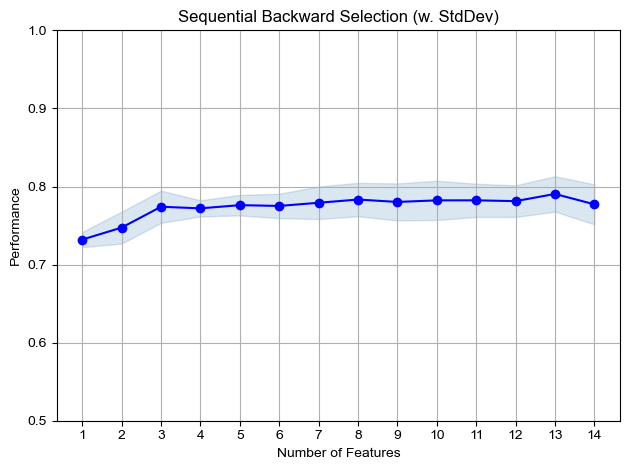

In [111]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

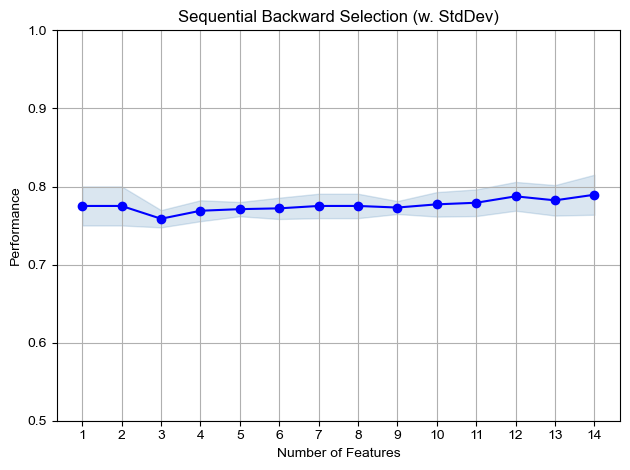

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [112]:
fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()